In [33]:
import os

# takes care of annoying TF-GPU warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# remove useless Tensorflow warning:
# WARNING:absl:Found untraced functions such as _update_step_xla, lstm_cell_1_layer_call_fn, 
# lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn, 
# lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 5 of 5). 
# These functions will not be directly callable after loading.
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [34]:
# very useful for managing wandb runs: https://stackoverflow.com/questions/71106179/log-two-model-runs-with-keras-wandb
import wandb
from wandb.keras import WandbCallback
os.environ["WANDB_SILENT"] = "true"

#### RNN: Formula Label Prediction (multi-label, all features)

In [35]:
import numpy as np 
import pandas as pd
from pathlib import Path 
import ast

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import keras_tuner as kt

import datetime

tfds.disable_progress_bar()
wandb_project_name = "multi_label_formula_classification"

In [36]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])

#### Import Data and Preprocess Dataframe

In [37]:
def preprocess_data(corpus,
                    irrelevant_features=["mtype",]):
    # drop irrelevant columns
    corpus.drop(irrelevant_features, inplace=True, axis=1)

    def cell_str_to_list(cell_val):
        return ast.literal_eval(cell_val)

    # filter strings
    def process_cell(cell_str):
        stripped_f_str = cell_str[1:-1].replace("\\\\", "\\")
        f_list = stripped_f_str.split(",")
        f_list = [token.replace("'", "").replace(" ", "") for token in f_list]
        f_list = ["{" if token == "\\{" else token for token in f_list]
        f_list = ["}" if token == "\\}" else token for token in f_list]
        cell_str = " ".join(f_list)
        return cell_str

    corpus["type_tokens"] = corpus["type_tokens"].map(process_cell)
    corpus["tokens"] = corpus["tokens"].map(process_cell)
    corpus["mtype_one_hot"] = corpus["mtype_one_hot"].map(cell_str_to_list)
    corpus["labels"] = corpus["labels"].map(cell_str_to_list)
    corpus = corpus.loc[(corpus["tokens"].str.len() > 0) & (corpus["tokens"] != " ")]


In [38]:
#print(os.getcwd())
data_p = Path("../data/") / "multi_class_unbalanced_data_TOKENIZED_V1.csv"
data = pd.read_csv(data_p)
preprocess_data(data)
data.head()

,tokens,type_tokens,labels,labels_str,mtype_one_hot
0,f,func_name __ANON_1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",['elementary-set-theory'],"[0, 0, 1]"
1,j : \mathbb{N} \rightarrow [ 0 1 ],func_def func_name __ANON_1 COLON mapping set_...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",['elementary-set-theory'],"[0, 0, 1]"
2,b,func_name __ANON_1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",['elementary-set-theory'],"[0, 0, 1]"
3,mathbb{Q,set_constant SET_BASIC,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",['elementary-set-theory'],"[1, 0, 0]"
4,f,func_name __ANON_1,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['functions', 'elementary-set-theory']","[0, 0, 1]"


In [39]:
print(data["type_tokens"].map(lambda x: len((x.split(" ")))).max())
print(data["tokens"].map(lambda x: len((x.split(" ")))).max())

254
252


In [40]:
# ordinary datasets
SMALL_TRAIN_SIZE = 24620 - 2460
SMALL_TEST_SIZE = 2460
LARGE_TRAIN_SIZE = 106523 - 10650
LARGE_TEST_SIZE = 10650
# compact datasets
NUM_CLASSES = 40

labels_array = np.array(data["labels"].to_list())
m_type_array = np.array(data["mtype_one_hot"].to_list())
data_as_ds = tf.data.Dataset.from_tensor_slices((data["tokens"],data["type_tokens"],m_type_array))
labels_ds = tf.data.Dataset.from_tensor_slices(labels_array)
data_as_ds = tf.data.Dataset.zip((data_as_ds, labels_ds))

test_dataset = data_as_ds.take(SMALL_TEST_SIZE)
train_dataset = data_as_ds.skip(SMALL_TEST_SIZE)

In [41]:
data_as_ds.element_spec

((TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(3,), dtype=tf.int64, name=None)),
 TensorSpec(shape=(40,), dtype=tf.int64, name=None))

##### Setup and Data Preparation

In [42]:
for (example_token, example_type, example_m_type), label in train_dataset.take(5):
    print("text: ", example_token.numpy())
    print("type: ", example_type.numpy())
    print("m_type: ", example_m_type.numpy())
    print("label: ", label.numpy())

text:  b'{ 2   4 }'
type:  b'explset L_BRACE_LITERAL set_enumeration item __ANON_3 COMMA item __ANON_3 R_BRACE_LITERAL'
m_type:  [1 0 0]
label:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
text:  b'f : I \\to X'
type:  b'func_def func_name __ANON_1 COLON mapping __ANON_0 TO __ANON_0'
m_type:  [0 0 1]
label:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
text:  b'f ( a ) = 1'
type:  b'func_expr func_name_arg func_name __ANON_1 L_PAREN __ANON_1 R_PAREN EQUAL expr_atom __ANON_3'
m_type:  [0 0 1]
label:  [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
text:  b'x'
type:  b'func_name __ANON_1'
m_type:  [0 0 1]
label:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
text:  b'f : X \\to Y'
type:  b'func_def func_name __ANON_1 COLON mapping __ANON_0 TO __ANON_0'
m_type:  [0 0 1]
label:  [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [43]:
BUFFER_SIZE = 2000
BATCH_SIZE = 64
STEPS_PER_EPOCH = np.floor(SMALL_TRAIN_SIZE/BATCH_SIZE)
VAL_STEPS_PER_EPOCH = np.floor(SMALL_TEST_SIZE/BATCH_SIZE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

##### Text Encoding

In [44]:
# for int encoder
TYPE_TOKENS_MAX_SEQ_LEN = 260
TOKENS_MAX_SEQ_LEN = 260

# for other encoders 
TYPE_TOKENS_PAD_TO_MAX_TOKENS = 80
TOKENS_PAD_TO_MAX_TOKENS = 200
BIGRAM_PAD_TO_MAX_TOKENS = 350

In [45]:
def create_encoder(output_mode_str, n_grams, mode):
    if output_mode_str == "int":
        VOCAB_SIZE = 200
        if mode == "token":
            max_seq_len = TOKENS_MAX_SEQ_LEN
        elif mode == "type":
            max_seq_len = TYPE_TOKENS_MAX_SEQ_LEN

        encoder = tf.keras.layers.TextVectorization(
            standardize=None,
            output_mode=output_mode_str,
            ngrams = n_grams,
            output_sequence_length = max_seq_len,
            split="whitespace",
            max_tokens=VOCAB_SIZE)
        #TODO: adapt for different inputs
        if mode == "token": 
            encoder.adapt(train_dataset.map(lambda inputs, label: inputs[0])) # removes the label column through transformation: text, label -> text
        elif mode == "type":
            encoder.adapt(train_dataset.map(lambda inputs, label: inputs[1])) # removes the label column through transformation: text, label -> text
        return encoder
    
    if output_mode_str == "count" and n_grams == 2:
        max_seq_len = BIGRAM_PAD_TO_MAX_TOKENS
        encoder = tf.keras.layers.TextVectorization(
            standardize=None,
            output_mode=output_mode_str,
            ngrams = n_grams,
            pad_to_max_tokens = max_seq_len,
            split="whitespace",
            max_tokens=max_seq_len)
        
        #TODO: adapt for different inputs
        if mode == "token": 
            encoder.adapt(train_dataset.map(lambda inputs, label: inputs[0])) # removes the label column through transformation: text, label -> text
        elif mode == "type":
            encoder.adapt(train_dataset.map(lambda inputs, label: inputs[1])) # removes the label column through transformation: text, label -> text
        return encoder
    
    if mode == "token":
        max_seq_len = TOKENS_PAD_TO_MAX_TOKENS
    elif mode == "type":
        max_seq_len = TYPE_TOKENS_PAD_TO_MAX_TOKENS

    encoder = tf.keras.layers.TextVectorization(
        standardize=None,
        output_mode=output_mode_str,
        ngrams = n_grams,
        pad_to_max_tokens = max_seq_len,
        split="whitespace",
        max_tokens=max_seq_len)
    #TODO: adapt for different inputs
    if mode == "token": 
        encoder.adapt(train_dataset.map(lambda inputs, label: inputs[0])) # removes the label column through transformation: text, label -> text
    elif mode == "type":
        encoder.adapt(train_dataset.map(lambda inputs, label: inputs[1])) # removes the label column through transformation: text, label -> text
    
    return encoder


    

##### Representation 1: Use integer indices encoding

In [46]:
encoder_int_tokens = create_encoder("int", None, "token")
encoder_int_types = create_encoder("int", None, "type")

vocab_tokens = np.array(encoder_int_tokens.get_vocabulary())
vocab_size_tokens = len(encoder_int_tokens.get_vocabulary())
vocab_types = np.array(encoder_int_types.get_vocabulary())
vocab_size_types = len(encoder_int_types.get_vocabulary())

print("tokens (voc size): ", vocab_size_tokens)
print("types (voc size): ", vocab_size_types)

tokens (voc size):  128
types (voc size):  61


In [47]:
encoded_example_token = encoder_int_tokens(example_token).numpy()
encoded_example_types = encoder_int_types(example_type).numpy()

print("tokens: ")
print(example_token)
print(encoded_example_token)
print(encoded_example_token.shape)

print("types: ")
print(example_type)
print(encoded_example_types)
print(encoded_example_types.shape)

tokens: 
tf.Tensor(b'f : X \\to Y', shape=(), dtype=string)
[ 2 11 26 14 35  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(260,)
types: 
tf.Tensor(b'func_def func_name __ANON_1 COLON mapping __ANON_0 TO __ANON_0', shape=(), dtype=string)
[15  5  3 13 14  6 16  6  0  0  

##### Representation 2: Count Vectorizer

In [48]:
encoder_count_tokens = create_encoder("count", None, "token")
encoder_count_types = create_encoder("count", None, "type")

vocab_tokens = np.array(encoder_count_tokens.get_vocabulary())
vocab_size_tokens = len(encoder_count_tokens.get_vocabulary())
vocab_types = np.array(encoder_count_types.get_vocabulary())
vocab_size_types = len(encoder_count_types.get_vocabulary())

print("tokens (voc size): ", vocab_size_tokens)
print("types (voc size): ", vocab_size_types)

tokens (voc size):  127
types (voc size):  60


In [49]:
encoded_example_token = encoder_count_tokens(example_token).numpy()
encoded_example_types = encoder_count_types(example_type).numpy()

print("tokens: ")
print(example_token)
print(encoded_example_token)
print(encoded_example_token.shape)

print("types: ")
print(example_type)
print(encoded_example_types)
print(encoded_example_types.shape)

tokens: 
tf.Tensor(b'f : X \\to Y', shape=(), dtype=string)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
(200,)
types: 
tf.Tensor(b'func_def func_name __ANON_1 COLON mapping __ANON_0 TO __ANON_0', shape=(), dtype=string)
[0. 0. 1. 0. 1. 2. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

##### Model (Bidirectional LSTM with one layer)

 **Define and compile model**

In [50]:
def create_model(tokens_encoder, types_encoder, tokens_size, types_size, input_type, add_inp_emb_dim=1):
    # model = create_model(encoder_count_tokens, encoder_count_types,tokens_input_len, "float", type_input_len)
    embedding_input_dim = tokens_size + types_size + add_inp_emb_dim + 3 # 3 size of sem_type_model_input

    tokens_model_input = tf.keras.layers.Input(dtype=tf.string, shape=(1,))
    tokens_vectorized = tokens_encoder(tokens_model_input)

    types_model_input = tf.keras.layers.Input(dtype=tf.string, shape=(1,))
    types_vectorized = types_encoder(types_model_input)

    if input_type == "float":
        sem_type_model_input = tf.keras.layers.Input(dtype=tf.float32, shape=(3,))
    elif input_type == "int":
        sem_type_model_input = tf.keras.layers.Input(dtype=tf.int64, shape=(3,))

    merged = tf.keras.layers.Concatenate(axis=1)([tokens_vectorized, types_vectorized, sem_type_model_input])

    embedded = tf.keras.layers.Embedding(input_dim= embedding_input_dim,
                                         output_dim=64,
                                         # user masking to handle the variable sequence lengths
                                         mask_zero=True)(merged)
    bilstmed = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(embedded)
    densed1 = tf.keras.layers.Dense(64, activation="relu")(bilstmed)
    model_output = tf.keras.layers.Dense(40)(densed1)


    model = tf.keras.models.Model(inputs=[tokens_model_input, types_model_input, sem_type_model_input], outputs=model_output)
    return model


 **Train the model**

##### Experiment 1: Use integer indices for encoding tokens

In [51]:
### TENSORBOARD USAGE
#log_dir = "4_nlp_rnns/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [52]:
tokens_input_len = TOKENS_MAX_SEQ_LEN 
type_input_len = TYPE_TOKENS_MAX_SEQ_LEN

model = create_model(encoder_int_tokens, encoder_int_types,tokens_input_len, type_input_len, "int")
"""
sample_text = "( A \cup B ) \cap (C \cup D )"
# predict on a sample formula using untrained model
predictions = model.predict(np.array([sample_text]))
print(predictions[0])
"""

'\nsample_text = "( A \\cup B ) \\cap (C \\cup D )"\n# predict on a sample formula using untrained model\npredictions = model.predict(np.array([sample_text]))\nprint(predictions[0])\n'

In [53]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_4 (TextVect  (None, 260)         0           ['input_7[0][0]']                
 orization)                                                                                       
                                                                                                  
 text_vectorization_5 (TextVect  (None, 260)         0           ['input_8[0][0]']          

In [54]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 60

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [55]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "BiLstm",
    "configuration": "small-ordinary-unbalanced-all-inputs",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "int",
    "dataset": "multi_class_unbalanced_data_TOKENIZED_V1"
}

run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, 
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    #steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/60
346/346 [==============================] - ETA: 0s - loss: 0.4337 - accuracy: 0.4047INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 98s 273ms/step - loss: 0.4337 - accuracy: 0.4047 - val_loss: 0.1834 - val_accuracy: 0.0979
Epoch 2/60
346/346 [==============================] - 80s 231ms/step - loss: 0.1500 - accuracy: 0.5968 - val_loss: 0.1886 - val_accuracy: 0.0000e+00
Epoch 3/60
346/346 [==============================] - 79s 229ms/step - loss: 0.1456 - accuracy: 0.5287 - val_loss: 0.1835 - val_accuracy: 0.0000e+00
Epoch 4/60
346/346 [==============================] - ETA: 0s - loss: 0.1452 - accuracy: 0.5014INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 94s 272ms/step - loss: 0.1452 - accuracy: 0.5014 - val_loss: 0.1801 - val_accuracy: 0.0000e+00
Epoch 5/60
346/346 [==============================] - ETA: 0s - loss: 0.1452 - accuracy: 0.4925INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 96s 277ms/step - loss: 0.1452 - accuracy: 0.4925 - val_loss: 0.1778 - val_accuracy: 0.0000e+00
Epoch 6/60
346/346 [==============================] - ETA: 0s - loss: 0.1456 - accuracy: 0.4730INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 95s 273ms/step - loss: 0.1456 - accuracy: 0.4730 - val_loss: 0.1768 - val_accuracy: 0.0000e+00
Epoch 7/60
346/346 [==============================] - 79s 228ms/step - loss: 0.1444 - accuracy: 0.4848 - val_loss: 0.1909 - val_accuracy: 0.0000e+00
Epoch 8/60
346/346 [==============================] - 79s 229ms/step - loss: 0.1455 - accuracy: 0.4704 - val_loss: 0.1817 - val_accuracy: 0.0000e+00
Epoch 9/60
346/346 [==============================] - 79s 228ms/step - loss: 0.1452 - accuracy: 0.4645 - val_loss: 0.1784 - val_accuracy: 0.0000e+00
Epoch 10/60
346/346 [==============================] - 79s 228ms/step - loss: 0.1446 - accuracy: 0.4817 - val_loss: 0.1785 - val_accuracy: 0.0000e+00
Epoch 11/60
346/346 [==============================] - ETA: 0s - loss: 0.1447 - accuracy: 0.4687INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 94s 271ms/step - loss: 0.1447 - accuracy: 0.4687 - val_loss: 0.1767 - val_accuracy: 0.0000e+00
Epoch 12/60
346/346 [==============================] - 79s 229ms/step - loss: 0.1438 - accuracy: 0.4947 - val_loss: 0.1777 - val_accuracy: 0.0000e+00
Epoch 13/60
346/346 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.4723INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 94s 272ms/step - loss: 0.1441 - accuracy: 0.4723 - val_loss: 0.1746 - val_accuracy: 0.0000e+00
Epoch 14/60
346/346 [==============================] - ETA: 0s - loss: 0.1428 - accuracy: 0.5016INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 94s 273ms/step - loss: 0.1428 - accuracy: 0.5016 - val_loss: 0.1711 - val_accuracy: 0.0000e+00
Epoch 15/60
346/346 [==============================] - 79s 229ms/step - loss: 0.1411 - accuracy: 0.5308 - val_loss: 0.1717 - val_accuracy: 0.0000e+00
Epoch 16/60
346/346 [==============================] - ETA: 0s - loss: 0.1402 - accuracy: 0.5353INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 95s 273ms/step - loss: 0.1402 - accuracy: 0.5353 - val_loss: 0.1702 - val_accuracy: 0.0000e+00
Epoch 17/60
346/346 [==============================] - 80s 231ms/step - loss: 0.1372 - accuracy: 0.5637 - val_loss: 0.1713 - val_accuracy: 0.0000e+00
Epoch 18/60
346/346 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 0.5675INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 95s 275ms/step - loss: 0.1362 - accuracy: 0.5675 - val_loss: 0.1638 - val_accuracy: 0.0000e+00
Epoch 19/60
346/346 [==============================] - ETA: 0s - loss: 0.1353 - accuracy: 0.5720INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 94s 273ms/step - loss: 0.1353 - accuracy: 0.5720 - val_loss: 0.1633 - val_accuracy: 0.0000e+00
Epoch 20/60
346/346 [==============================] - ETA: 0s - loss: 0.1344 - accuracy: 0.5769INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 94s 273ms/step - loss: 0.1344 - accuracy: 0.5769 - val_loss: 0.1623 - val_accuracy: 0.0000e+00
Epoch 21/60
346/346 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.5772INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 102s 295ms/step - loss: 0.1339 - accuracy: 0.5772 - val_loss: 0.1603 - val_accuracy: 0.0000e+00
Epoch 22/60
346/346 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.5845INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 94s 272ms/step - loss: 0.1327 - accuracy: 0.5845 - val_loss: 0.1598 - val_accuracy: 0.0267
Epoch 23/60
346/346 [==============================] - ETA: 0s - loss: 0.1325 - accuracy: 0.5863INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 91s 264ms/step - loss: 0.1325 - accuracy: 0.5863 - val_loss: 0.1583 - val_accuracy: 0.1628
Epoch 24/60
346/346 [==============================] - ETA: 0s - loss: 0.1322 - accuracy: 0.5893INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 93s 268ms/step - loss: 0.1322 - accuracy: 0.5893 - val_loss: 0.1575 - val_accuracy: 0.1805
Epoch 25/60
346/346 [==============================] - ETA: 0s - loss: 0.1322 - accuracy: 0.5863INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 91s 264ms/step - loss: 0.1322 - accuracy: 0.5863 - val_loss: 0.1544 - val_accuracy: 0.2019
Epoch 26/60
346/346 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.5863INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 93s 267ms/step - loss: 0.1319 - accuracy: 0.5863 - val_loss: 0.1533 - val_accuracy: 0.2056
Epoch 27/60
346/346 [==============================] - ETA: 0s - loss: 0.1314 - accuracy: 0.5914INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 92s 266ms/step - loss: 0.1314 - accuracy: 0.5914 - val_loss: 0.1512 - val_accuracy: 0.2233
Epoch 28/60
346/346 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.5870INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 92s 265ms/step - loss: 0.1316 - accuracy: 0.5870 - val_loss: 0.1498 - val_accuracy: 0.2475
Epoch 29/60
346/346 [==============================] - 77s 222ms/step - loss: 0.1303 - accuracy: 0.5993 - val_loss: 0.1501 - val_accuracy: 0.2775
Epoch 30/60
346/346 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.6013INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 92s 265ms/step - loss: 0.1301 - accuracy: 0.6013 - val_loss: 0.1487 - val_accuracy: 0.2956
Epoch 31/60
346/346 [==============================] - 78s 224ms/step - loss: 0.1301 - accuracy: 0.5951 - val_loss: 0.1523 - val_accuracy: 0.3084
Epoch 32/60
346/346 [==============================] - ETA: 0s - loss: 0.1300 - accuracy: 0.5971INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 94s 271ms/step - loss: 0.1300 - accuracy: 0.5971 - val_loss: 0.1485 - val_accuracy: 0.3647
Epoch 33/60
346/346 [==============================] - ETA: 0s - loss: 0.1298 - accuracy: 0.5959INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 100s 290ms/step - loss: 0.1298 - accuracy: 0.5959 - val_loss: 0.1470 - val_accuracy: 0.3869
Epoch 34/60
346/346 [==============================] - ETA: 0s - loss: 0.1297 - accuracy: 0.5942INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 106s 307ms/step - loss: 0.1297 - accuracy: 0.5942 - val_loss: 0.1459 - val_accuracy: 0.4153
Epoch 35/60
346/346 [==============================] - 93s 270ms/step - loss: 0.1294 - accuracy: 0.6003 - val_loss: 0.1476 - val_accuracy: 0.3380
Epoch 36/60
346/346 [==============================] - 92s 266ms/step - loss: 0.1291 - accuracy: 0.5967 - val_loss: 0.1459 - val_accuracy: 0.3713
Epoch 37/60
346/346 [==============================] - 91s 264ms/step - loss: 0.1289 - accuracy: 0.6002 - val_loss: 0.1488 - val_accuracy: 0.2648
Epoch 38/60
346/346 [==============================] - 91s 262ms/step - loss: 0.1290 - accuracy: 0.5949 - val_loss: 0.1469 - val_accuracy: 0.2738
Epoch 39/60
346/346 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.5964INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 118s 341ms/step - loss: 0.1293 - accuracy: 0.5964 - val_loss: 0.1435 - val_accuracy: 0.3762
Epoch 40/60
346/346 [==============================] - 110s 318ms/step - loss: 0.1292 - accuracy: 0.5951 - val_loss: 0.1436 - val_accuracy: 0.3499
Epoch 41/60
346/346 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.5967INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 144s 416ms/step - loss: 0.1289 - accuracy: 0.5967 - val_loss: 0.1430 - val_accuracy: 0.3660
Epoch 42/60
346/346 [==============================] - 105s 304ms/step - loss: 0.1286 - accuracy: 0.6001 - val_loss: 0.1437 - val_accuracy: 0.4449
Epoch 43/60
346/346 [==============================] - 93s 268ms/step - loss: 0.1285 - accuracy: 0.6013 - val_loss: 0.1436 - val_accuracy: 0.3684
Epoch 44/60
346/346 [==============================] - 88s 254ms/step - loss: 0.1284 - accuracy: 0.5973 - val_loss: 0.1434 - val_accuracy: 0.3503
Epoch 45/60
346/346 [==============================] - 96s 278ms/step - loss: 0.1284 - accuracy: 0.5972 - val_loss: 0.1432 - val_accuracy: 0.3030
Epoch 46/60
346/346 [==============================] - ETA: 0s - loss: 0.1285 - accuracy: 0.5991INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 115s 333ms/step - loss: 0.1285 - accuracy: 0.5991 - val_loss: 0.1420 - val_accuracy: 0.3174
Epoch 47/60
346/346 [==============================] - ETA: 0s - loss: 0.1283 - accuracy: 0.5993INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 122s 353ms/step - loss: 0.1283 - accuracy: 0.5993 - val_loss: 0.1392 - val_accuracy: 0.4560
Epoch 48/60
346/346 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.6031INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 134s 388ms/step - loss: 0.1281 - accuracy: 0.6031 - val_loss: 0.1391 - val_accuracy: 0.4576
Epoch 49/60
346/346 [==============================] - 119s 344ms/step - loss: 0.1281 - accuracy: 0.6034 - val_loss: 0.1397 - val_accuracy: 0.3775
Epoch 50/60
346/346 [==============================] - ETA: 0s - loss: 0.1279 - accuracy: 0.6066INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 124s 359ms/step - loss: 0.1279 - accuracy: 0.6066 - val_loss: 0.1389 - val_accuracy: 0.4260
Epoch 51/60
346/346 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.6042INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 121s 349ms/step - loss: 0.1280 - accuracy: 0.6042 - val_loss: 0.1376 - val_accuracy: 0.4753
Epoch 52/60
346/346 [==============================] - ETA: 0s - loss: 0.1278 - accuracy: 0.6052INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 111s 320ms/step - loss: 0.1278 - accuracy: 0.6052 - val_loss: 0.1375 - val_accuracy: 0.4766
Epoch 53/60
346/346 [==============================] - ETA: 0s - loss: 0.1276 - accuracy: 0.6063INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 110s 318ms/step - loss: 0.1276 - accuracy: 0.6063 - val_loss: 0.1371 - val_accuracy: 0.4774
Epoch 54/60
346/346 [==============================] - ETA: 0s - loss: 0.1276 - accuracy: 0.6091INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 117s 337ms/step - loss: 0.1276 - accuracy: 0.6091 - val_loss: 0.1362 - val_accuracy: 0.4819
Epoch 55/60
346/346 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.6117INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 118s 341ms/step - loss: 0.1274 - accuracy: 0.6117 - val_loss: 0.1353 - val_accuracy: 0.4864
Epoch 56/60
346/346 [==============================] - 107s 308ms/step - loss: 0.1274 - accuracy: 0.6115 - val_loss: 0.1354 - val_accuracy: 0.4951
Epoch 57/60
346/346 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.6105INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 125s 362ms/step - loss: 0.1274 - accuracy: 0.6105 - val_loss: 0.1341 - val_accuracy: 0.4984
Epoch 58/60
346/346 [==============================] - 111s 321ms/step - loss: 0.1269 - accuracy: 0.6114 - val_loss: 0.1347 - val_accuracy: 0.4996
Epoch 59/60
346/346 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.6091INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_191148-8p0tpjdr/files/model-best/assets


346/346 [==============================] - 118s 341ms/step - loss: 0.1271 - accuracy: 0.6091 - val_loss: 0.1337 - val_accuracy: 0.5000
Epoch 60/60
346/346 [==============================] - 107s 309ms/step - loss: 0.1271 - accuracy: 0.6105 - val_loss: 0.1338 - val_accuracy: 0.5021


In [56]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

38/38 [==============================] - 3s 88ms/step - loss: 0.1338 - accuracy: 0.5021
Test Loss: 0.13376925885677338
Test Accuracy: 0.5020559430122375


(0.0, 0.44901426434516906)

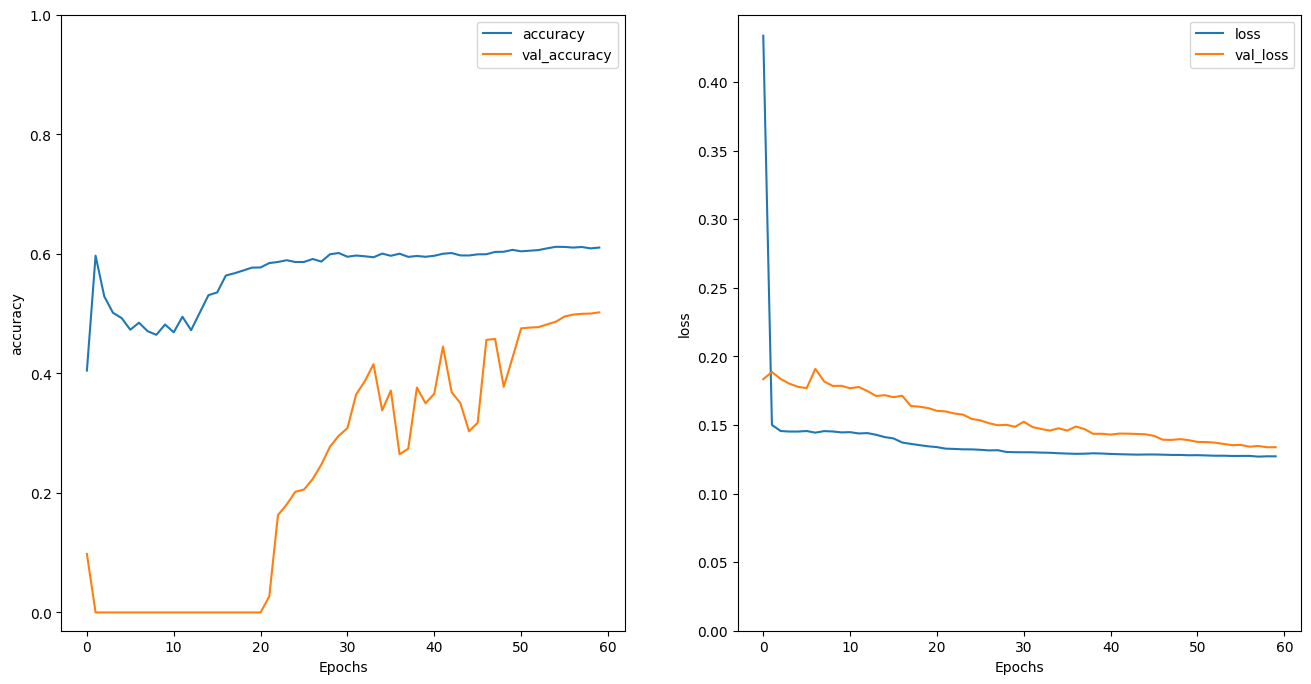

In [57]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [26]:

# predict on a sample text without padding
"""
predictions = model.predict((np.array([example_token]), np.array([example_type])))
print(predictions[0])
"""

'\npredictions = model.predict((np.array([example_token]), np.array([example_type])))\nprint(predictions[0])\n'

##### Experiment 2:

In [27]:
tokens_input_len = TOKENS_PAD_TO_MAX_TOKENS 
type_input_len = TYPE_TOKENS_PAD_TO_MAX_TOKENS

model = create_model(encoder_count_tokens, encoder_count_types,tokens_input_len, type_input_len, "float") # maybe add 30
# predict on a sample formula using untrained model
#predictions = model.predict(np.array([sample_text]))
#print(predictions[0])

In [28]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 25
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [29]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "BiLstm",
    "configuration": "small-ordinary-unbalanced-all-inputs",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "count",
    "dataset": "multi_class_unbalanced_data_TOKENIZED_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, 
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/25
346/346 [==============================] - ETA: 0s - loss: 0.4301 - accuracy: 0.2208INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


346/346 [==============================] - 62s 171ms/step - loss: 0.4301 - accuracy: 0.2208 - val_loss: 0.2122 - val_accuracy: 0.0000e+00
Epoch 2/25
346/346 [==============================] - ETA: 0s - loss: 0.1594 - accuracy: 0.5362INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


346/346 [==============================] - 58s 167ms/step - loss: 0.1594 - accuracy: 0.5362 - val_loss: 0.1864 - val_accuracy: 0.0000e+00
Epoch 3/25
346/346 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.5250INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


346/346 [==============================] - 59s 171ms/step - loss: 0.1483 - accuracy: 0.5250 - val_loss: 0.1747 - val_accuracy: 0.0000e+00
Epoch 4/25
346/346 [==============================] - ETA: 0s - loss: 0.1468 - accuracy: 0.5109INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


346/346 [==============================] - 61s 177ms/step - loss: 0.1468 - accuracy: 0.5109 - val_loss: 0.1708 - val_accuracy: 0.0000e+00
Epoch 5/25
346/346 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.5079INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


346/346 [==============================] - 59s 171ms/step - loss: 0.1461 - accuracy: 0.5079 - val_loss: 0.1699 - val_accuracy: 0.0000e+00
Epoch 6/25
346/346 [==============================] - 44s 127ms/step - loss: 0.1458 - accuracy: 0.5070 - val_loss: 0.1703 - val_accuracy: 0.0000e+00
Epoch 7/25
346/346 [==============================] - 44s 127ms/step - loss: 0.1457 - accuracy: 0.5037 - val_loss: 0.1703 - val_accuracy: 0.0000e+00
Epoch 8/25
346/346 [==============================] - 43s 125ms/step - loss: 0.1457 - accuracy: 0.4984 - val_loss: 0.1709 - val_accuracy: 0.0000e+00
Epoch 9/25
346/346 [==============================] - 44s 126ms/step - loss: 0.1458 - accuracy: 0.4937 - val_loss: 0.1717 - val_accuracy: 0.0000e+00
Epoch 10/25
346/346 [==============================] - 44s 127ms/step - loss: 0.1459 - accuracy: 0.4855 - val_loss: 0.1722 - val_accuracy: 0.0000e+00
Epoch 11/25
346/346 [==============================] - 44s 127ms/step - loss: 0.1459 - accuracy: 0.4819 - val_loss: 

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


346/346 [==============================] - 60s 172ms/step - loss: 0.1468 - accuracy: 0.4306 - val_loss: 0.1697 - val_accuracy: 0.0000e+00
Epoch 20/25
346/346 [==============================] - ETA: 0s - loss: 0.1471 - accuracy: 0.4236INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


346/346 [==============================] - 58s 168ms/step - loss: 0.1471 - accuracy: 0.4236 - val_loss: 0.1682 - val_accuracy: 0.0000e+00
Epoch 21/25
346/346 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.4201INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


346/346 [==============================] - 58s 169ms/step - loss: 0.1470 - accuracy: 0.4201 - val_loss: 0.1667 - val_accuracy: 0.0000e+00
Epoch 22/25
346/346 [==============================] - ETA: 0s - loss: 0.1469 - accuracy: 0.4191INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


346/346 [==============================] - 58s 169ms/step - loss: 0.1469 - accuracy: 0.4191 - val_loss: 0.1664 - val_accuracy: 0.0000e+00
Epoch 23/25
346/346 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.4160INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


346/346 [==============================] - 58s 168ms/step - loss: 0.1470 - accuracy: 0.4160 - val_loss: 0.1656 - val_accuracy: 0.0000e+00
Epoch 24/25
346/346 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.4127INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


346/346 [==============================] - 59s 170ms/step - loss: 0.1470 - accuracy: 0.4127 - val_loss: 0.1647 - val_accuracy: 0.0000e+00
Epoch 25/25
346/346 [==============================] - ETA: 0s - loss: 0.1469 - accuracy: 0.4073INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_multilabel/wandb/run-20230312_182317-2o2mpr5q/files/model-best/assets


346/346 [==============================] - 58s 168ms/step - loss: 0.1469 - accuracy: 0.4073 - val_loss: 0.1637 - val_accuracy: 0.0000e+00


In [30]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

38/38 [==============================] - 1s 39ms/step - loss: 0.1637 - accuracy: 0.0000e+00
Test Loss: 0.1637251377105713
Test Accuracy: 0.0


(0.0, 0.4443638429045677)

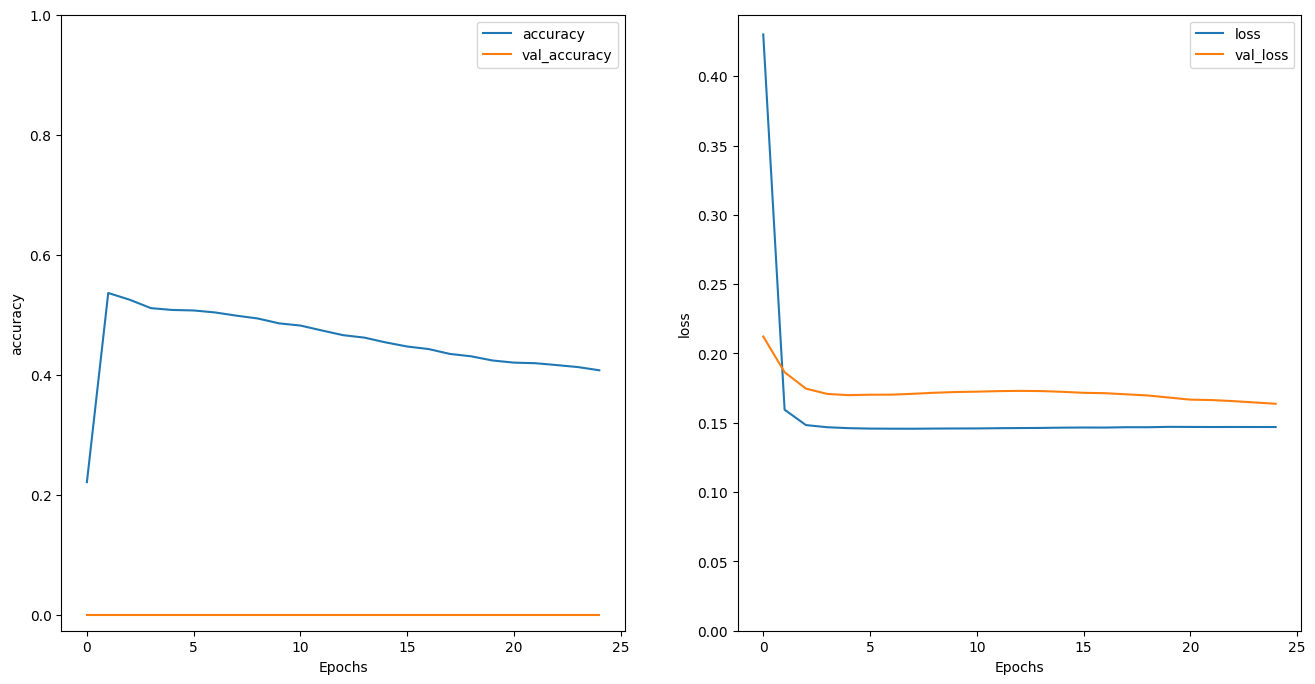

In [31]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [32]:
"""
# predict on a sample text without padding
predictions = model.predict(np.array([sample_text]))
print(predictions[0])
"""

'\n# predict on a sample text without padding\npredictions = model.predict(np.array([sample_text]))\nprint(predictions[0])\n'